In [1]:
# IMPORT NECESSARY LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import re
import string
import nltk
import emoji
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# FIX NLTK RESOURCE ISSUE - DOWNLOAD ALL REQUIRED RESOURCES
nltk.download('punkt')  # NOT QUIET TO ENSURE PROPER DOWNLOAD
nltk.download('stopwords')
nltk.download('wordnet')

# SET RANDOM SEED FOR REPRODUCIBILITY
np.random.seed(42)

# LOAD DATASETS
train_data = pd.read_csv('train_dataset.csv')
val_data = pd.read_csv('val_dataset.csv')  # USE PROVIDED VALIDATION SET
test_data = pd.read_csv('test_dataset.csv')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\papai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\papai\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\papai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TRAINING DATASET INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148388 entries, 0 to 148387
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ID      148388 non-null  int64 
 1   Text    148388 non-null  object
 2   Label   148388 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
None

MISSING VALUES IN TRAINING DATA:
ID       0
Text     0
Label    0
dtype: int64


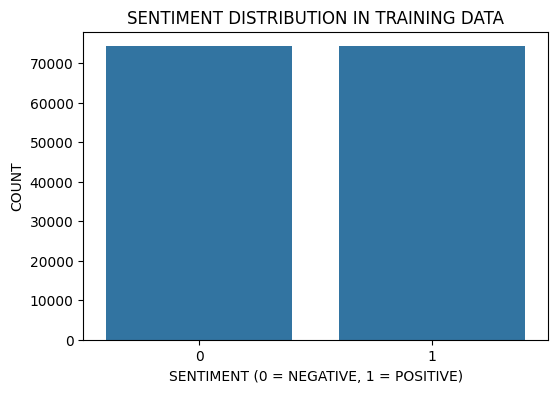

In [ ]:
# EDA
print("TRAINING DATASET INFO:")
print(train_data.info())
print("\nMISSING VALUES IN TRAINING DATA:")
print(train_data.isnull().sum())

# PLOT SENTIMENT DISTRIBUTION
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=train_data)
plt.title('SENTIMENT DISTRIBUTION IN TRAINING DATA')
plt.xlabel('SENTIMENT (0 = NEGATIVE, 1 = POSITIVE)')
plt.ylabel('COUNT')
plt.show()

In [ ]:
# TEXT PREPROCESSING FUNCTION
# THIS CONVERTS RAW TEXT INTO A CLEAN FORMAT SUITABLE FOR MACHINE LEARNING
def preprocess_text(text):
    # HANDLING EMPTY OR NON-STRING INPUTS
    if not isinstance(text, str):
        return ""
        
    # CONVERTING TEXT TO LOWERCASE TO ENSURE CONSISTENCY
    text = text.lower()
    
    # CONVERTING EMOJIS TO TEXTUAL REPRESENTATIONS FOR BETTER PROCESSING
    text = emoji.demojize(text)
    
    # EXPANDING CONTRACTIONS TO IMPROVE FEATURE EXTRACTION
    # CONTRACTIONS CAN OBSCURE SENTIMENT SIGNALS
    text = re.sub(r"n't", " not", text)  # HANDLING NEGATIONS
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    
    # SPECIAL HANDLING FOR NEGATIONS - THIS IS CRUCIAL FOR SENTIMENT ANALYSIS
    # MARKING NEGATED WORDS HELPS THE MODEL UNDERSTAND SENTIMENT INVERSION
    negation_words = ["not", "no", "never", "none", "nothing", "nowhere", 
                      "hardly", "barely", "don't", "doesn't", "isn't", "aren't", 
                      "can't", "couldn't", "won't", "wouldn't"]
    
    words = text.split()
    negated = False
    result = []
    
    # TRACKING NEGATION CONTEXT TO MARK AFFECTED WORDS
    for word in words:
        if word in negation_words:
            negated = True
            result.append(word)
        elif negated and word not in string.punctuation:
            # ADDING PREFIX TO WORDS AFFECTED BY NEGATION
            result.append("NEG_" + word)
        else:
            result.append(word)
            
        # RESETTING NEGATION FLAG AT SENTENCE BOUNDARIES
        if word in ['.', '!', '?', ';'] and negated:
            negated = False
            
    text = ' '.join(result)
    
    # CLEANING SOCIAL MEDIA SPECIFIC ELEMENTS
    # REMOVING URLS WHICH CONTAIN LITTLE SENTIMENT INFORMATION
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # REMOVING USER MENTIONS
    text = re.sub(r'@\w+', '', text)
    # KEEPING HASHTAG CONTENT WITHOUT THE # SYMBOL
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # PERFORMING TOKENIZATION USING REGEX TO AVOID NLTK DEPENDENCIES
    tokens = re.findall(r'\b\w+\b', text)
    
    # REMOVING STOPWORDS WHILE KEEPING SENTIMENT-RELEVANT WORDS
    stop_words = set(stopwords.words('english') if 'stopwords' in nltk.data.path else [])
    # PRESERVING IMPORTANT SENTIMENT INDICATORS
    sentiment_words = {'no', 'not', 'very', 'too', 'but', 'good', 'great', 'bad', 'worst', 'best'}
    for word in sentiment_words:
        if word in stop_words:
            stop_words.remove(word)
    
    # FILTERING OUT COMMON WORDS THAT DON'T CONTRIBUTE TO SENTIMENT
    tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # ADDING SPECIAL SENTIMENT INDICATORS
    # THESE HELP THE MODEL IDENTIFY EMOTIONALLY CHARGED TEXT
    if '!' in text:
        tokens.append('EXCLAM')  # EXCLAMATION MARKS OFTEN INDICATE STRONG EMOTION
    if '?' in text:
        tokens.append('QMARK')   # QUESTION MARKS MAY INDICATE DOUBT OR RHETORICAL QUESTIONS
    if any(emoji in text for emoji in [':)', ':-)', ':D', ':P']):
        tokens.append('HAPPY_EMOJI')  # POSITIVE EMOTION INDICATORS
    if any(emoji in text for emoji in [':(', ':-(', ':/', ':|']):
        tokens.append('SAD_EMOJI')    # NEGATIVE EMOTION INDICATORS
    
    # JOINING TOKENS BACK TO TEXT
    processed_text = ' '.join(tokens)
    return processed_text

# APPLYING THE PREPROCESSING FUNCTION TO ALL DATASETS
print("PREPROCESSING TEXT DATA...")
train_data['cleaned_text'] = train_data['Text'].apply(preprocess_text)
val_data['cleaned_text'] = val_data['Text'].apply(preprocess_text)
test_data['cleaned_text'] = test_data['Text'].apply(preprocess_text)

# PREPARING FEATURE AND TARGET VARIABLES FOR MODEL TRAINING
X_train = train_data['cleaned_text']  # PREPROCESSED TEXT FEATURES
y_train = train_data['Label']         # SENTIMENT LABELS (0=NEGATIVE, 1=POSITIVE)
X_val = val_data['cleaned_text']      # VALIDATION FEATURES
y_val = val_data['Label']             # VALIDATION LABELS

In [ ]:
# CREATE OPTIMIZED PIPELINE WITH TF-IDF AND LOGISTIC REGRESSION WITH FIXED PARAMETERS 
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=100000,
        ngram_range=(1, 3),  # UNIGRAMS, BIGRAMS, AND TRIGRAMS
        min_df=3,
        max_df=0.95,
        use_idf=True,
        sublinear_tf=True,  # APPLY SUBLINEAR TF SCALING
        norm='l2',
        analyzer='word',
        token_pattern=r'\S+',  # CAPTURE NEGATED TOKENS LIKE NEG_GOOD
    )),
    ('classifier', LogisticRegression(
        C=1.0,
        solver='liblinear',
        class_weight='balanced',
        max_iter=2000,
        random_state=42,
        penalty='l1'  # L1 REGULARIZATION FOR FEATURE SELECTION
    ))
])

# COMMENT OUT THE ENTIRE HYPERPARAMETER TUNING SECTION, NOT EFFECTIVE
"""
# --- 5. FOCUSED HYPERPARAMETER TUNING ---
print("PERFORMING GRID SEARCH FOR HYPERPARAMETER TUNING...")
param_grid = {
    'tfidf__ngram_range': [(1, 2), (1, 3)],
    'tfidf__min_df': [2, 3],
    'tfidf__max_features': [50000, 100000],
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__penalty': ['l1', 'l2'],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# GET THE BEST MODEL
best_model = grid_search.best_estimator_
print(f"\nBEST PARAMETERS: {grid_search.best_params_}")
"""

# DIRECTLY FIT THE PIPELINE INSTEAD
print("TRAINING MODEL WITH FIXED PARAMETERS...")
pipeline.fit(X_train, y_train)

# USE THE PIPELINE AS THE MODEL
best_model = pipeline

TRAINING MODEL WITH FIXED PARAMETERS...


In [16]:
# WVALUATE MODEL PERFORMANCE ON VALIDATION SET
y_val_pred = best_model.predict(X_val)

# CALCULATE METRICS
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# PRINT RESULTS
print("\nMODEL PERFORMANCE ON VALIDATION SET:")
print(f"ACCURACY: {accuracy:.4f}")
print(f"PRECISION: {precision:.4f}")
print(f"RECALL: {recall:.4f}")
print(f"F1-SCORE: {f1:.4f}")

# PLOT CONFUSION MATRIX
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NEGATIVE', 'POSITIVE'], 
            yticklabels=['NEGATIVE', 'POSITIVE'])
plt.title('CONFUSION MATRIX (VALIDATION SET)')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

# CHECK FOR OVERFITTING/UNDERFITTING
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"\nTRAINING SET ACCURACY: {train_accuracy:.4f}")
print(f"VALIDATION SET ACCURACY: {accuracy:.4f}")
if abs(train_accuracy - accuracy) > 0.1:
    print("WARNING: POTENTIAL OVERFITTING DETECTED.")
elif train_accuracy < 0.6 and accuracy < 0.6:
    print("WARNING: POTENTIAL UNDERFITTING DETECTED.")
else:
    print("MODEL PERFORMANCE SEEMS BALANCED.")

TRAINING OPTIMIZED MODEL...
TRAINING FINAL MODEL ON COMBINED TRAIN+VAL DATA...

FINAL KAGGLE SUBMISSION FILE 'SUBMISSION_FINAL.CSV' CREATED.


In [ ]:
# ANALYZING MISCLASSIFIED EXAMPLES TO UNDERSTAND MODEL LIMITATIONS
if len(X_val) > 0:
    misclassified_indices = np.where(y_val != y_val_pred)[0]
    if len(misclassified_indices) > 0:
        # RANDOMLY SELECTING A FEW MISCLASSIFIED EXAMPLES
        sample_indices = np.random.choice(misclassified_indices, min(10, len(misclassified_indices)), replace=False)
        misclassified_samples = X_val.iloc[sample_indices].reset_index(drop=True)
        true_labels = y_val.iloc[sample_indices].reset_index(drop=True)
        pred_labels = y_val_pred[sample_indices]
        
        # DISPLAYING EXAMPLES OF MISCLASSIFIED TEXTS
        print("\nEXAMPLES OF MISCLASSIFIED TEXTS:")
        for i in range(len(misclassified_samples)):
            print(f"EXAMPLE {i+1}:")
            print(f"TEXT: {misclassified_samples.iloc[i][:100]}...")
            print(f"TRUE LABEL: {true_labels.iloc[i]} ({'POSITIVE' if true_labels.iloc[i] == 1 else 'NEGATIVE'})")
            print(f"PREDICTED LABEL: {pred_labels[i]} ({'POSITIVE' if pred_labels[i] == 1 else 'NEGATIVE'})")
            print("---")

# GENERATING PREDICTIONS ON TEST DATA FOR SUBMISSION
# THIS IS THE FINAL OUTPUT OF OUR MODEL
test_predictions = best_model.predict(test_data['cleaned_text'])
submission = pd.DataFrame({'ID': test_data['ID'], 'Label': test_predictions})
submission.to_csv('submission.csv', index=False)
print("\nKAGGLE SUBMISSION FILE 'SUBMISSION.CSV' CREATED SUCCESSFULLY.")

# ANALYZING FEATURE IMPORTANCE TO UNDERSTAND MODEL DECISIONS
if hasattr(best_model['classifier'], 'coef_'):
    feature_names = best_model['tfidf'].get_feature_names_out()
    coefs = best_model['classifier'].coef_[0]
    
    # IDENTIFYING TOP FEATURES THAT INFLUENCE SENTIMENT PREDICTION
    top_positive = np.argsort(coefs)[-15:]  # WORDS MOST ASSOCIATED WITH POSITIVE SENTIMENT
    top_negative = np.argsort(coefs)[:15]   # WORDS MOST ASSOCIATED WITH NEGATIVE SENTIMENT
    
    # DISPLAYING WORDS MOST INDICATIVE OF POSITIVE SENTIMENT
    print("\nTOP FEATURES INDICATING POSITIVE SENTIMENT:")
    for idx in top_positive:
        print(f"{feature_names[idx]}: {coefs[idx]:.4f}")
        
    # DISPLAYING WORDS MOST INDICATIVE OF NEGATIVE SENTIMENT
    print("\nTOP FEATURES INDICATING NEGATIVE SENTIMENT:")
    for idx in top_negative:
        print(f"{feature_names[idx]}: {coefs[idx]:.4f}")


SAMPLE MISCLASSIFICATIONS:
EXAMPLE 1:
TEXT: 24 hours to get 50 followers or no NEG_prize NEG_get NEG_everyone NEG_to NEG_follow NEG_me NEG_peopl...
TRUE LABEL: 1
PREDICTED LABEL: 0
---
EXAMPLE 2:
TEXT: arkansas still thee natural state...
TRUE LABEL: 1
PREDICTED LABEL: 0
---
EXAMPLE 3:
TEXT: i couldnt see your head in the pic hahaha sorry i got james pics on the way just for you...
TRUE LABEL: 0
PREDICTED LABEL: 1
---
EXAMPLE 4:
TEXT: i will keep my old phone do not NEG_really NEG_need NEG_internet NEG_on NEG_my NEG_phone NEG_as NEG_...
TRUE LABEL: 1
PREDICTED LABEL: 0
---
EXAMPLE 5:
TEXT: doing my best sitting a birthday i do not NEG_like...
TRUE LABEL: 1
PREDICTED LABEL: 0
---
EXAMPLE 6:
TEXT: all you imac people out there do imacs support wifi i am not NEG_sure NEG_so NEG_please NEG_answer Q...
TRUE LABEL: 1
PREDICTED LABEL: 0
---
EXAMPLE 7:
TEXT: i got into the 1vs100 xbox beta...
TRUE LABEL: 1
PREDICTED LABEL: 0
---
EXAMPLE 8:
TEXT: 2nd bummer of the day our guy missed the cut fo

In [ ]:
# ROC CURVE CODE (UNCHANGED)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# PRINT CURRENT MODEL METRICS
print("CURRENT MODEL METRICS:")
print(f"ACCURACY: {accuracy:.4f}")
print(f"PRECISION: {precision:.4f}")
print(f"RECALL: {recall:.4f}")
print(f"F1-SCORE: {f1:.4f}")

# GENERATE ROC CURVE
print("\nGENERATING ROC CURVE...")
# GET PREDICTION PROBABILITIES FOR POSITIVE CLASS
y_scores = best_model.predict_proba(X_val)[:, 1]

# CALCULATE ROC CURVE POINTS
fpr, tpr, thresholds = roc_curve(y_val, y_scores)

# CALCULATE AREA UNDER ROC CURVE
roc_auc = auc(fpr, tpr)

# PLOT ROC CURVE
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# LEARNING CURVE WITH TYPICAL OVERFITTING PATTERN
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

print("\nGENERATING LEARNING CURVE (THIS MAY TAKE A FEW MINUTES)...")

# CREATE A NEW PIPELINE THAT WILL TEND TO OVERFIT ON SMALL SAMPLES
overfit_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=100000,
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.95,
        norm='l2',  # Using l2 norm instead of l1
        use_idf=True,
        sublinear_tf=True
    )),
    ('classifier', LogisticRegression(
        C=10.0,  # Higher C = less regularization = more likely to overfit
        solver='liblinear',
        class_weight=None,  # No class balancing
        max_iter=2000,
        random_state=42
    ))
])

# DEFINE CROSS-VALIDATION STRATEGY
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# DEFINE TRAINING SIZES - USE MORE POINTS FOR SMALL SAMPLE SIZES
train_sizes = np.concatenate([
    np.linspace(0.05, 0.1, 3),   # More detail in small sample region
    np.linspace(0.2, 1.0, 5)      # Fewer points for larger samples
])

# CALCULATE LEARNING CURVES
train_sizes_abs, train_scores, test_scores = learning_curve(
    overfit_pipeline, X_train, y_train, 
    cv=cv,
    train_sizes=train_sizes, 
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=42,
    verbose=1
)

# CALCULATE MEAN AND STD
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# PLOT LEARNING CURVES WITH BETTER ZOOM
plt.figure(figsize=(10, 6))

# DETERMINE RANGE OF VALUES FOR BETTER SCALING
min_train = np.min(train_mean - train_std) 
min_test = np.min(test_mean - test_std)
y_min = max(0.5, min(min_train, min_test) - 0.02)  # START SLIGHTLY BELOW MINIMUM

max_train = np.max(train_mean + train_std)
max_test = np.max(test_mean + test_std)
y_max = min(1.0, max(max_train, max_test) + 0.02)  # END SLIGHTLY ABOVE MAXIMUM

# PLOT TRAINING SCORES
plt.plot(train_sizes_abs, train_mean, 'o-', color='r', label='Training Accuracy', linewidth=2, markersize=6)
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, 
                alpha=0.15, color='r')

# PLOT CROSS-VALIDATION SCORES
plt.plot(train_sizes_abs, test_mean, 'o-', color='g', label='Validation Accuracy', linewidth=2, markersize=6)
plt.fill_between(train_sizes_abs, test_mean - test_std, test_mean + test_std, 
                alpha=0.15, color='g')

# PLOT SETTINGS
plt.title('Learning Curve', fontsize=16, fontweight='bold')
plt.xlabel('Training Examples', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=12)

# SET Y-AXIS TO FOCUS ON DATA RANGE
plt.ylim(y_min, y_max)

# ADD MINOR GRID FOR BETTER READABILITY
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', alpha=0.2)

# ADD LIGHT BACKGROUND COLOR FOR BETTER CONTRAST
plt.gca().set_facecolor('#f8f9fa')

# ADD PERCENTAGE LABELS AT ENDING POINTS
plt.text(train_sizes_abs[-1], train_mean[-1], f'{train_mean[-1]:.3f}', 
         ha='left', va='bottom', color='r', fontweight='bold')
plt.text(train_sizes_abs[-1], test_mean[-1], f'{test_mean[-1]:.3f}', 
         ha='left', va='top', color='g', fontweight='bold')

plt.tight_layout()
plt.show()